In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from textblob import Word
import nltk
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [4]:
#load in dataset
df = pd.read_csv('data\\added_features.csv', index_col = 0)

In [5]:
df.head()

,title,text,label,text_wc,title_wc,av_word_len_text,av_word_len_title,upper_text_wc,upper_title_wc,numerics_text,numerics_title,exclam_text,exclam_title,qmark_text,qmark_title,at_sign,stop_p,weekend,Sep_Dec
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,1,495,12,4.804040,5.583333,5,0,4,0,6,0,9,0,13,0.375758,1,1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,1,305,8,5.213115,7.625000,3,0,0,0,0,0,0,0,0,0.390164,1,1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",1,580,15,5.168966,5.000000,42,0,0,0,2,0,4,0,14,0.360345,1,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",1,444,14,5.180180,4.571429,5,1,5,0,0,0,1,0,8,0.360360,0,1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,1,420,11,4.554762,5.363636,0,0,0,0,0,0,0,0,0,0.464286,0,1


In [6]:
#make all words lowercase
df['text'] = df.text.str.lower()
df['title'] = df.title.str.lower()

In [7]:
#remove all punctuation
df['title'] = df.title.str.replace('[^\w\s]', '')
df['text'] = df.text.str.replace('[^\w\s]', '')

In [8]:
#remove numerics
df['title'] = df.title.str.replace('[0-9]', '')

In [9]:
#remove stopwords
stop = stopwords.words('english')
df['title'] = df.title.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['text'] = df.text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [10]:
#lemmatization
df['text'] = df.text.apply(lambda x: " ".join(Word(word).lemmatize() for word in x.split()))
df['title'] = df.title.apply(lambda x: " ".join(Word(word).lemmatize() for word in x.split()))

In [11]:
#tokenization of title
cv = CountVectorizer(max_features=100)
title_counts = cv.fit_transform(df.title).toarray()

In [12]:
#make data drame of title word counts 
feature_names = cv.get_feature_names()
title_counts_df = pd.DataFrame(title_counts, columns=feature_names).add_prefix('title_cv_')

In [13]:
#compile list of most frequent words used in the title
title_counts_df.sum().sort_values(ascending=False)

title_cv_trump      12740
title_cv_video       6352
title_cv_say         3759
title_cv_house       1855
title_cv_obama       1842
                    ...  
title_cv_factbox      416
title_cv_would        411
title_cv_brexit       410
title_cv_gun          404
title_cv_day          400
Length: 100, dtype: int64

In [14]:
#tokenization of text 
cv = CountVectorizer(max_features=100)
cv.fit_transform(df.text)
#make a dataframe of text word counts
text_counts = cv.fit_transform(df.text).toarray()
feature_names = cv.get_feature_names()
text_counts_df = pd.DataFrame(text_counts, columns=feature_names).add_prefix('text_cv_')

In [15]:
#compile list of most frequently used words in the text 
text_counts_df.sum().sort_values(ascending=False)

text_cv_said         120692
text_cv_trump        117296
text_cv_state         51830
text_cv_would         49295
text_cv_president     46260
                      ...  
text_cv_plan          10013
text_cv_go             9972
text_cv_saying         9957
text_cv_world          9946
text_cv_public         9924
Length: 100, dtype: int64

In [16]:
#remove words specifically used by reuters
df.title = df.title.str.replace('reuters', '')
df.text = df.text.str.replace('reuters', '')
df.title = df.title.str.replace('via', '')
df.text = df.text.str.replace('via', '')

In [17]:
#sentiment analysis
title_sentiment = df['title'].apply(lambda x: TextBlob(x).sentiment)
text_sentiment = df['text'].apply(lambda x: TextBlob(x).sentiment)

In [18]:
#create dataframe of polarity and subjectivity for title
polarity=[]
subjectivity = []
for row in range(len(title_sentiment)):
    polarity.append(title_sentiment[row][0])
    subjectivity.append(title_sentiment[row][1])
title_sentiment = pd.DataFrame({'title_polarity':polarity,'title_subjectivity':subjectivity})

In [19]:
#create dataframe of polarity and subjectivity for text
polarity=[]
subjectivity = []
for row in range(len(text_sentiment)):
    polarity.append(text_sentiment[row][0])
    subjectivity.append(text_sentiment[row][1])
text_sentiment = pd.DataFrame({'text_polarity':polarity,'text_subjectivity':subjectivity})

In [20]:
#add label column for comparison analysis
text_sentiment['label']=df.label
title_sentiment['label'] = df.label
text_sentiment.groupby('label').mean()

,text_polarity,text_subjectivity
label,,
0,0.042765,0.347272
1,0.045423,0.427747


In [21]:
title_sentiment.groupby('label').mean()

,title_polarity,title_subjectivity
label,,
0,0.022012,0.172421
1,-0.003320,0.365189


In [22]:
#combine rows of fake article titles into one string
fake_title_string = " ".join(row for row in df[df.label == 1].title)
#combine rows of true article titles into one string
true_title_string = " ".join(row for row in df[df.label==0].title)
#combine rows of fake article text into one string
fake_text_string= " ".join(row for row in df[df.label==1].text)
#combine rows of true article text into one string
true_text_string= " ".join(row for row in df[df.label==0].text)
#create a dictionary of strings and their variable names
string_dict = {'fake_title': fake_title_string, 'true_title': true_title_string, 'fake_text':fake_text_string, 'true_text':true_text_string}

In [23]:
#create a function to make a word cloud from a string
def make_word_cloud(string):
    wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10)
    cloud = wordcloud.generate(string) 
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(cloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

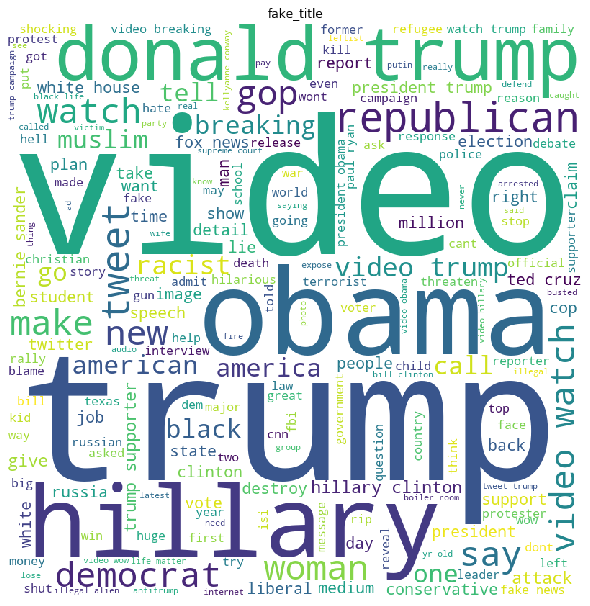

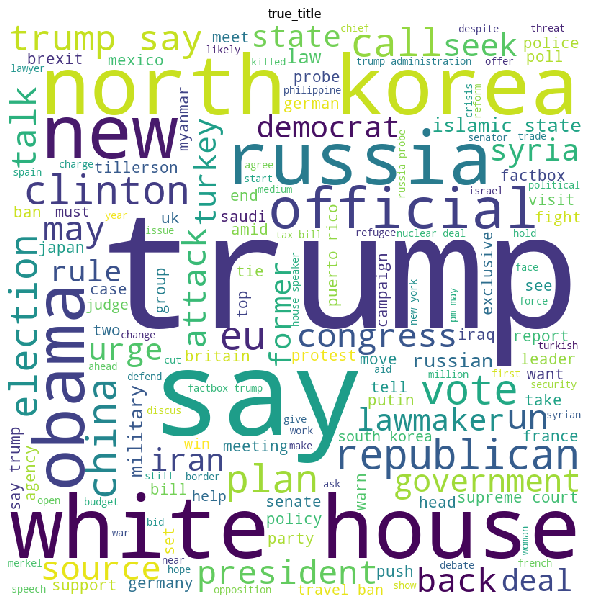

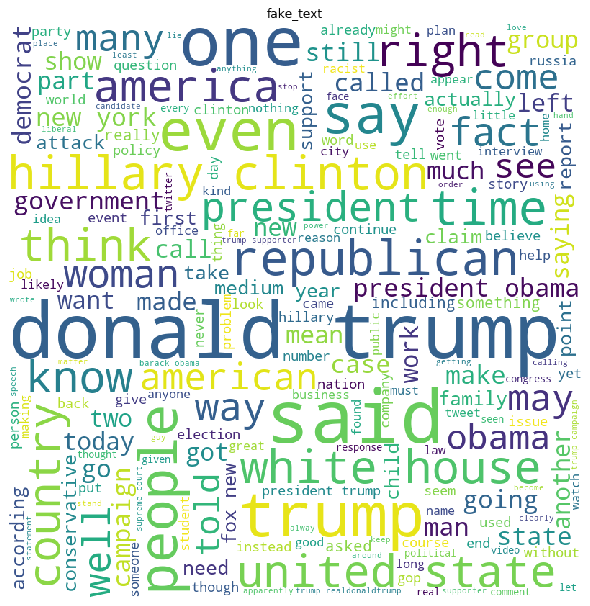

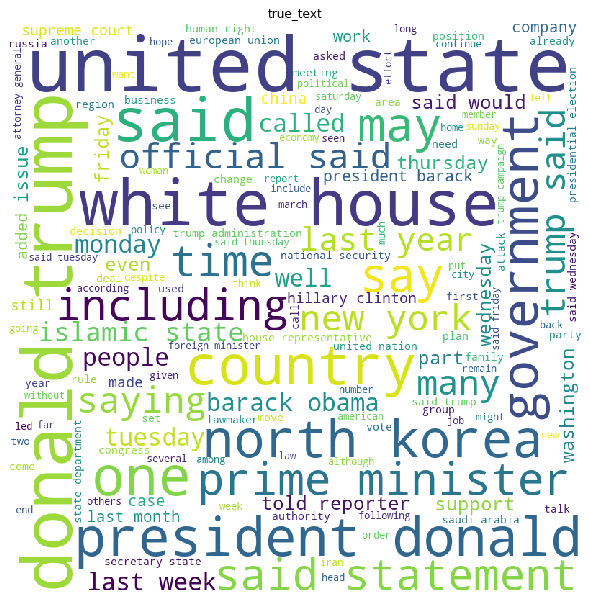

In [24]:
#iterate through string dictionary to create 4 word clouds separated by string types and labels
for name, string in string_dict.items():
    make_word_cloud(string)
    plt.title(name)

In [25]:
#create a text tfidf vectorizer of unigrams and bigrams, limited to 800 features
tfidf= TfidfVectorizer(ngram_range=(1,2), max_features=800)
#make a datafame of text tfidf values
text_n_gram = tfidf.fit_transform(df['text']).toarray()
feature_names = tfidf.get_feature_names()
text_n_gram_df = pd.DataFrame(text_n_gram, columns= feature_names).add_prefix('text_ngram_')

In [26]:
text_n_gram_df.sum().sort_values(ascending=False)

text_ngram_trump                   3581.989561
text_ngram_said                    2884.323395
text_ngram_state                   1536.597107
text_ngram_president               1489.335252
text_ngram_would                   1397.410052
                                      ...     
text_ngram_obama administration     149.928254
text_ngram_criticism                149.821370
text_ngram_raised                   149.249973
text_ngram_benefit                  147.325345
text_ngram_dont                     143.490737
Length: 800, dtype: float64

In [27]:
#create a title tfidf vectorizer of unigrams and bigrams, limited to 200 features
tfidf= TfidfVectorizer(ngram_range=(1,2), max_features=200)
#make a dataframe of title tfidf values
title_n_gram = tfidf.fit_transform(df['title']).toarray()
feature_names = tfidf.get_feature_names()
title_n_gram_df = pd.DataFrame(title_n_gram, columns= feature_names).add_prefix('title_ngram_')

In [28]:
title_n_gram_df.sum().sort_values(ascending=False)

title_ngram_trump              3844.327359
title_ngram_video              2391.098721
title_ngram_say                1526.216485
title_ngram_obama               876.433422
title_ngram_republican          844.789792
                                  ...     
title_ngram_britain             160.910592
title_ngram_trump supporter     158.111306
title_ngram_next                154.303880
title_ngram_bernie              153.366726
title_ngram_fox news            142.241794
Length: 200, dtype: float64

In [29]:
#add tfidf features to basic features to create the model dataframe
model_df = pd.concat([df.drop(['text', 'title'], axis=1), title_n_gram_df, text_n_gram_df], axis=1)

In [30]:
model_df

,label,text_wc,title_wc,av_word_len_text,av_word_len_title,upper_text_wc,upper_title_wc,numerics_text,numerics_title,exclam_text,...,text_ngram_worker,text_ngram_working,text_ngram_world,text_ngram_would,text_ngram_wrong,text_ngram_wrote,text_ngram_year,text_ngram_yet,text_ngram_york,text_ngram_young
0,1,495,12,4.804040,5.583333,5,0,4,0,6,...,0.0,0.00000,0.000000,0.042374,0.051551,0.0,0.397070,0.000000,0.000000,0.000000
1,1,305,8,5.213115,7.625000,3,0,0,0,0,...,0.0,0.00000,0.075998,0.000000,0.000000,0.0,0.000000,0.000000,0.174931,0.000000
2,1,580,15,5.168966,5.000000,42,0,0,0,2,...,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,1,444,14,5.180180,4.571429,5,1,5,0,0,...,0.0,0.05844,0.000000,0.087214,0.000000,0.0,0.034052,0.000000,0.000000,0.000000
4,1,420,11,4.554762,5.363636,0,0,0,0,0,...,0.0,0.00000,0.065641,0.000000,0.000000,0.0,0.000000,0.076686,0.000000,0.092756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39099,0,463,9,5.008639,5.888889,14,2,3,0,0,...,0.0,0.00000,0.000000,0.109288,0.000000,0.0,0.085341,0.000000,0.000000,0.000000
39100,0,122,7,5.336066,6.571429,0,0,0,0,0,...,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.143636,0.000000,0.000000,0.000000
39101,0,317,7,5.044164,6.142857,4,0,3,0,0,...,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.198407,0.000000,0.000000,0.000000
39102,0,202,9,4.806931,5.888889,0,0,0,0,0,...,0.0,0.00000,0.182360,0.000000,0.000000,0.0,0.063188,0.000000,0.000000,0.000000


In [36]:
#export data to csv
model_df.to_csv('data\model_df.csv')